In [1]:
#Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

#Advance
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

## Data Preparation

In [2]:
#@title LOAD DATASET


def read_with_sniff(filepath):
    """
    Membaca file CSV dengan otomatis mendeteksi delimiter.
    """
    with open(filepath, "r") as f:
        sample = f.read(2048)
        dialect = csv.Sniffer().sniff(sample)
        delim = dialect.delimiter

    df = pd.read_csv(filepath, delimiter=delim)
    return df, delim

dataset, delim = read_with_sniff("/content/drive/MyDrive/UAS DATA SCIENCE/Acoustic Features.csv")
print("Delimiter terdeteksi:", delim)
print("Shape dataset:", dataset.shape)

# Mengubah nama kolom menjadi konsisten (tanpa spasi dan huruf besar)
dataset.columns = dataset.columns.str.replace(" ", "_").str.replace("-", "_")

Delimiter terdeteksi: ,
Shape dataset: (400, 51)


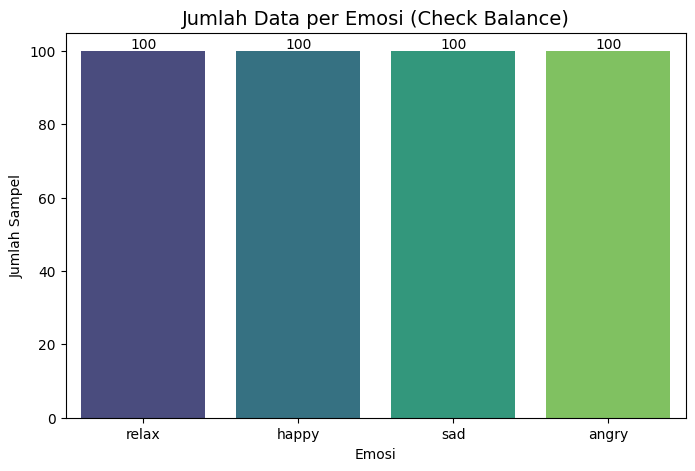

In [3]:
#@title 1.0 VISUALISASI UTAMA ( DISTRIBUSI CLASS )
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Class', data=dataset, palette='viridis')
plt.title('Jumlah Data per Emosi (Check Balance)', fontsize=14)
plt.ylabel('Jumlah Sampel')
plt.xlabel('Emosi')

# Menampilkan angka di atas batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

In [4]:
#@title 1.2 CEK DUPLICATES

print("\n=== CEK DUPLICATES ===")
duplicate_count = dataset.duplicated().sum()
print("Jumlah duplikasi:", duplicate_count)

if duplicate_count > 0:
    dataset = dataset.drop_duplicates()
    print("Duplikasi dihapus. Shape baru:", dataset.shape)
else:
    print("Tidak ada duplikasi.")


=== CEK DUPLICATES ===
Jumlah duplikasi: 12
Duplikasi dihapus. Shape baru: (388, 51)


In [5]:
#@title 1.1 CEK MISSING VALUES

print("\n=== CEK MISSING VALUES ===")
missing_values = dataset.isnull().sum()
print(missing_values)

# Simpan kolom yang memiliki missing
missing_cols = missing_values[missing_values > 0].index.tolist()

if len(missing_cols) > 0:
    print("\nKolom dengan missing:", missing_cols)

    # IMPUTASI median (karena fitur bersifat skewed)
    for col in missing_cols:
        median_val = dataset[col].median()
        dataset[col] = dataset[col].fillna(median_val)
        print(f"Imputasi kolom '{col}' dengan median: {median_val}")

else:
    print("\nTidak ditemukan missing values.")


=== CEK MISSING VALUES ===
Class                                             0
_RMSenergy_Mean                                   0
_Lowenergy_Mean                                   0
_Fluctuation_Mean                                 0
_Tempo_Mean                                       0
_MFCC_Mean_1                                      0
_MFCC_Mean_2                                      0
_MFCC_Mean_3                                      0
_MFCC_Mean_4                                      0
_MFCC_Mean_5                                      0
_MFCC_Mean_6                                      0
_MFCC_Mean_7                                      0
_MFCC_Mean_8                                      0
_MFCC_Mean_9                                      0
_MFCC_Mean_10                                     0
_MFCC_Mean_11                                     0
_MFCC_Mean_12                                     0
_MFCC_Mean_13                                     0
_Roughness_Mean                     

In [6]:
# @title 1.3 HANDLING OUTLIERS (ANALISIS IQR, TIDAK MENGHAPUS DATA)

print("\n=== OUTLIER ANALYSIS ===")

# Kita tambahkan "_" di depan karena di CSV aslinya ada
paket_A = [
    '_RMSenergy_Mean',
    '_Tempo_Mean',
    '_Spectralcentroid_Mean',
    '_Spectralflatness_Mean',
    '_MFCC_Mean_1',
    '_EntropyofSpectrum_Mean'
]

# Pastikan hanya mengambil kolom yang benar-benar ada
valid_features = [c for c in paket_A if c in dataset.columns]

if len(valid_features) == 0:
    print("PERINGATAN: Tidak ada fitur yang cocok! Cek kembali nama kolom di dataset.")
else:
    # Hitung IQR
    Q1 = dataset[valid_features].quantile(0.25)
    Q3 = dataset[valid_features].quantile(0.75)
    IQR = Q3 - Q1

    # Deteksi outlier
    outlier_mask = ((dataset[valid_features] < (Q1 - 1.5 * IQR)) |
                    (dataset[valid_features] > (Q3 + 1.5 * IQR)))

    outlier_count = outlier_mask.sum()
    print("\nJumlah outlier per fitur:")
    print(outlier_count)

    # Tidak menghapus outlier → hanya analisis
    print("\nKESIMPULAN: Outlier dianalisis tetapi TIDAK DIHAPUS.")
    print("Alasan: Dalam data audio emosi, nilai ekstrem (seperti suara teriakan/marah)")


=== OUTLIER ANALYSIS ===

Jumlah outlier per fitur:
_RMSenergy_Mean             3
_Tempo_Mean                 0
_Spectralcentroid_Mean      3
_Spectralflatness_Mean      9
_MFCC_Mean_1               14
_EntropyofSpectrum_Mean    12
dtype: int64

KESIMPULAN: Outlier dianalisis tetapi TIDAK DIHAPUS.
Alasan: Dalam data audio emosi, nilai ekstrem (seperti suara teriakan/marah)


In [7]:
#@title 1.4 DATA TYPE VALIDATION

print("\n=== CEK DATA TYPES ===")
print(dataset.dtypes)

# Coba konversi otomatis jika ada kolom numerik yang terbaca sebagai object
for col in paket_A:
    if dataset[col].dtype == "object":
        dataset[col] = pd.to_numeric(dataset[col], errors="coerce")

print("\nData types setelah perbaikan:")
print(dataset[paket_A].dtypes)

# Cek missing baru setelah konversi
new_missing = dataset[paket_A].isnull().sum()
print("\nMissing baru setelah konversi (jika ada):")
print(new_missing)

# Imputasi jika ada missing baru
if new_missing.sum() > 0:
    for col in paket_A:
        median_val = dataset[col].median()
        dataset[col] = dataset[col].fillna(median_val)


=== CEK DATA TYPES ===
Class                                              object
_RMSenergy_Mean                                   float64
_Lowenergy_Mean                                   float64
_Fluctuation_Mean                                 float64
_Tempo_Mean                                       float64
_MFCC_Mean_1                                      float64
_MFCC_Mean_2                                      float64
_MFCC_Mean_3                                      float64
_MFCC_Mean_4                                      float64
_MFCC_Mean_5                                      float64
_MFCC_Mean_6                                      float64
_MFCC_Mean_7                                      float64
_MFCC_Mean_8                                      float64
_MFCC_Mean_9                                      float64
_MFCC_Mean_10                                     float64
_MFCC_Mean_11                                     float64
_MFCC_Mean_12                                   

In [8]:
#@title Filtering Class"
print("\n=== FILTERING KELAS (HAPPY & ANGRY ONLY) ===")

# Filter dataset: Hanya ambil baris yang Class-nya 'happy' atau 'angry'
dataset_filtered = dataset[dataset['Class'].isin(['happy', 'angry'])].copy()

# Reset index agar rapi (0 sampai selesai)
dataset_filtered.reset_index(drop=True, inplace=True)

print(f"Shape awal        : {dataset.shape}")
print(f"Shape setelah filter: {dataset_filtered.shape}")
print(f"Sisa Kelas        : {dataset_filtered['Class'].unique()}")

# Supaya cell-cell di bawahnya otomatis pakai data yang sudah bersih ini
dataset = dataset_filtered


=== FILTERING KELAS (HAPPY & ANGRY ONLY) ===
Shape awal        : (388, 51)
Shape setelah filter: (193, 51)
Sisa Kelas        : ['happy' 'angry']


Menganalisis 6 fitur dari variabel 'paket_A'...


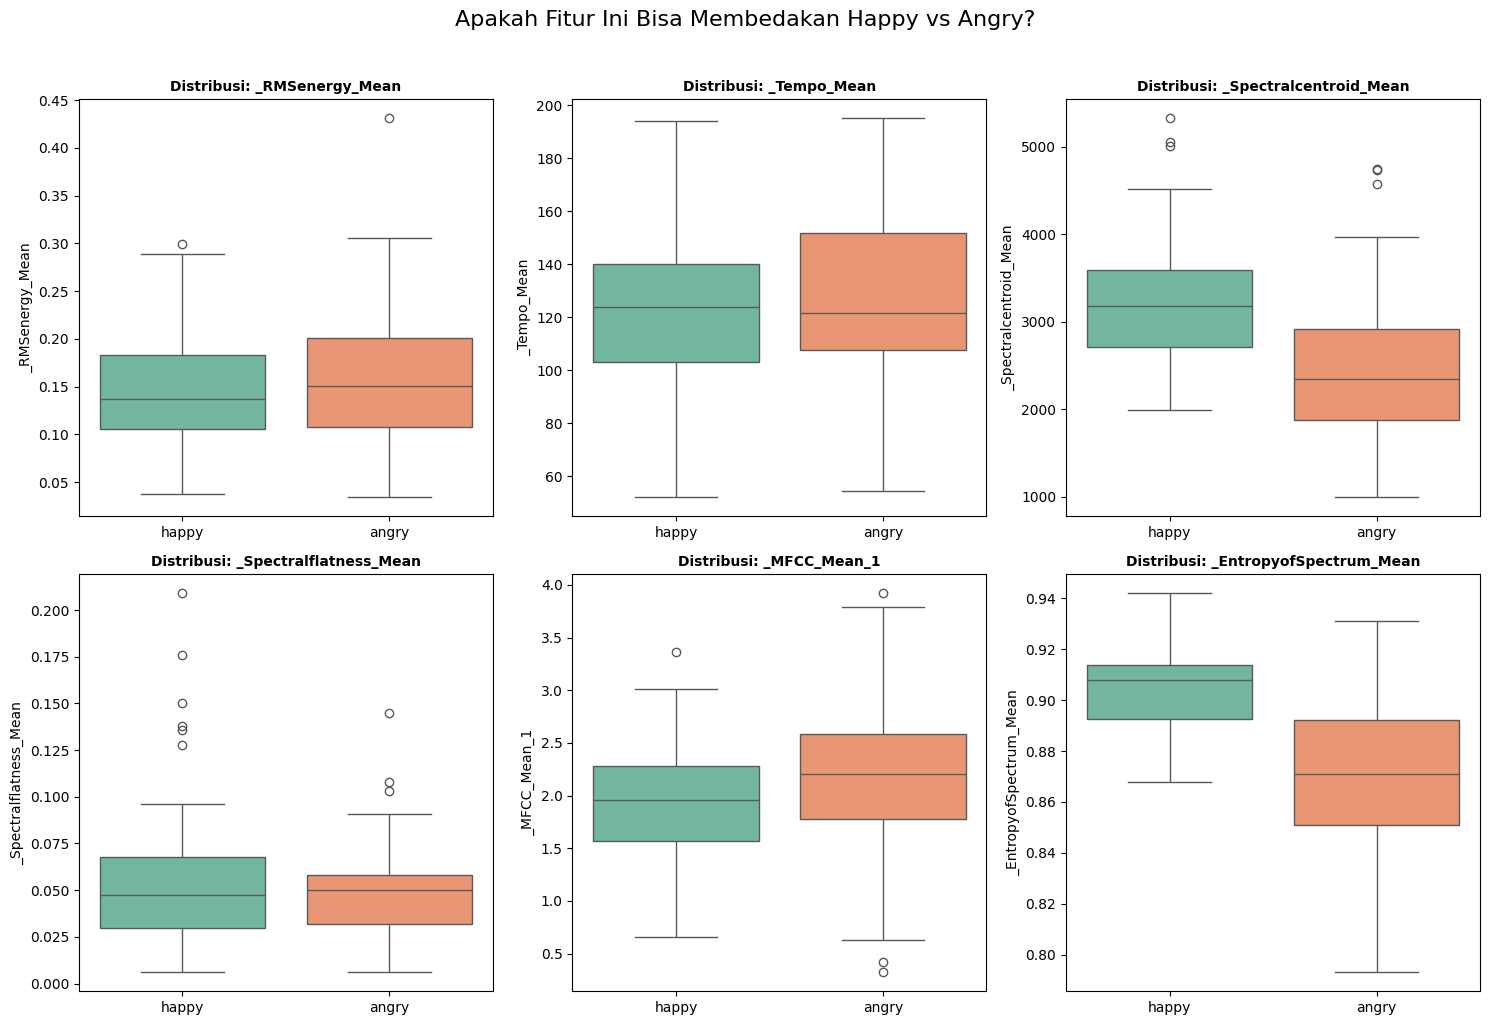

In [9]:
# @title 1.5 EXPLORATORY DATA ANALYSIS ( Boxplot Comparison )

print(f"Menganalisis {len(paket_A)} fitur dari variabel 'paket_A'...")
plt.figure(figsize=(15, 10)) # Ukuran gambar
for i, col in enumerate(paket_A):
    # Cek dulu apakah kolom ada di dataset (untuk keamanan)
    if col in dataset.columns:
        plt.subplot(2, 3, i + 1) # Membuat kotak grid 2 baris x 3 kolom
        sns.boxplot(x='Class', y=col, data=dataset, palette='Set2')
        plt.title(f'Distribusi: {col}', fontsize=10, fontweight='bold')
        plt.xlabel('') # Hilangkan label x biar rapi
    else:
        print(f"Skip: Fitur {col} tidak ditemukan di kolom dataset.")

plt.suptitle('Apakah Fitur Ini Bisa Membedakan Happy vs Angry?', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

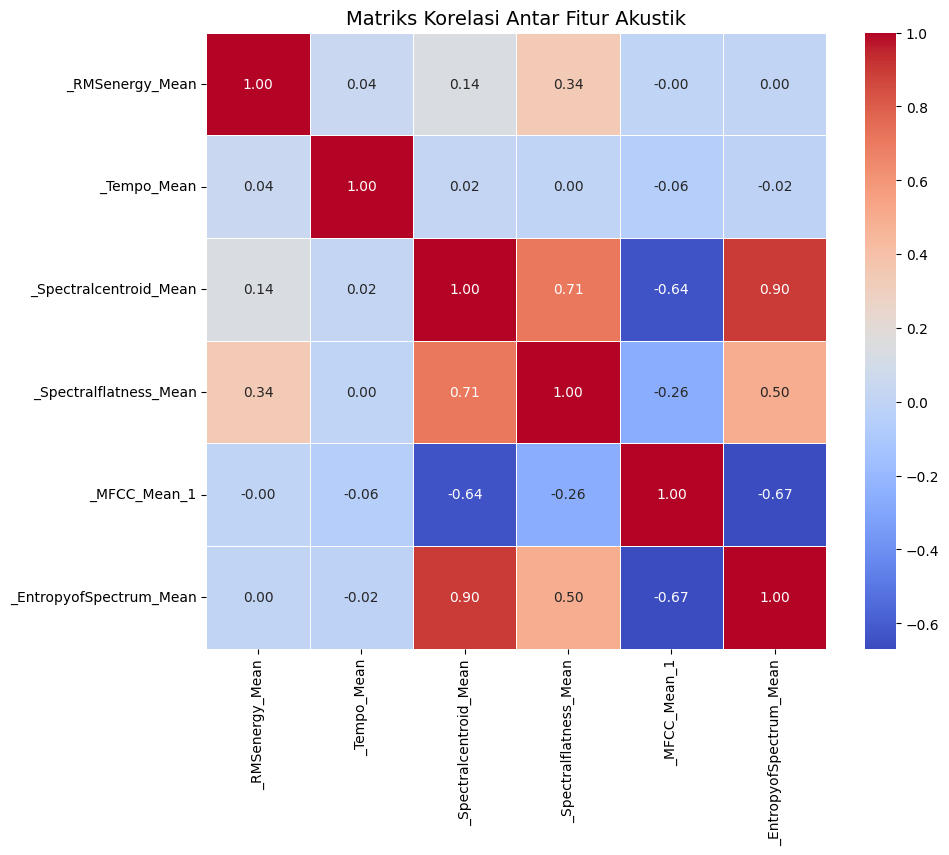

In [10]:
# @title 1.5.1 CORRELATION HEATMAP

# Define fitur_eda before use
fitur_eda = paket_A
plt.figure(figsize=(10, 8))
# Hitung korelasi hanya untuk kolom fitur numerik pilihan
corr_matrix = dataset[fitur_eda].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriks Korelasi Antar Fitur Akustik', fontsize=14)
plt.show()


## **2.Feature Engineering**

In [11]:
#@title Creating New Features

# Tambah satu fitur turunan sederhana (energi per tempo)
#dataset["EnergyTempo_Ratio"] = dataset["_RMSenergy_Mean"] / (dataset["_Tempo_Mean"] + 1e-9)

#print("New feature created: EnergyTempo_Ratio")

In [12]:
#@title Feature Extraction

dataset["Log_Spectralcentroid"] = np.log(dataset["_Spectralcentroid_Mean"] + 1)
print("Feature extracted: Log_Spectralcentroid")

Feature extracted: Log_Spectralcentroid


In [13]:
#@title Feature Selection ( 6 FEATURES)

# 1. Definisikan 6 Fitur Pilihan Anda
paket_fix = [
    'RMSenergy_Mean',
    'Tempo_Mean',
    'Spectralcentroid_Mean',
    'Spectralflatness_Mean',
    'MFCC_Mean_1',
    'EntropyofSpectrum_Mean'
]

print("Mencari kolom yang sesuai di dataset...")

# 2. Cari nama kolom asli di dataset (kadang ada underscore _ di depannya)
selected_cols = []
for target in paket_fix:
    found = False
    for col in dataset.columns:
        # Cek jika nama target ada di dalam nama kolom dataset
        if target in col:
            selected_cols.append(col)
            found = True
            break
    if not found:
        print(f"WARNING: Fitur '{target}' tidak ditemukan di dataset!")

# 3. Definisikan X dan y baru
X = dataset[selected_cols]
y = dataset["Class"]

print("\nFITUR FINAL YANG DIGUNAKAN (X):")
print(selected_cols)
print(f"\nShape X Akhir: {X.shape}")
# Harusnya output shape kolomnya (..., 6)

Mencari kolom yang sesuai di dataset...

FITUR FINAL YANG DIGUNAKAN (X):
['_RMSenergy_Mean', '_Tempo_Mean', '_Spectralcentroid_Mean', '_Spectralflatness_Mean', '_MFCC_Mean_1', '_EntropyofSpectrum_Mean']

Shape X Akhir: (193, 6)


In [14]:
#@title Dimensionality Reduction (Optional PCA)

# Hanya reduksi 2 dimensi agar visualisasi mudah
#pca = PCA(n_components=2)
#X_pca = pca.fit_transform(X)
#
#print("PCA performed: shape =", X_pca.shape)

In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 52 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Class                                           193 non-null    object 
 1   _RMSenergy_Mean                                 193 non-null    float64
 2   _Lowenergy_Mean                                 193 non-null    float64
 3   _Fluctuation_Mean                               193 non-null    float64
 4   _Tempo_Mean                                     193 non-null    float64
 5   _MFCC_Mean_1                                    193 non-null    float64
 6   _MFCC_Mean_2                                    193 non-null    float64
 7   _MFCC_Mean_3                                    193 non-null    float64
 8   _MFCC_Mean_4                                    193 non-null    float64
 9   _MFCC_Mean_5                               

# 3. Data Transformation (Untuk Data Tabular )

In [16]:
# 3.1 Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label encoding selesai. Label unik:", label_encoder.classes_)

Label encoding selesai. Label unik: ['angry' 'happy']


In [17]:
# 3.2 Feature Scaling (StandardScaler)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaling selesai. Shape fitur:", X_scaled.shape)

Scaling selesai. Shape fitur: (193, 6)


4. Spliting Data

In [18]:
# @title Data Splitting

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 2. Split Data 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"Jumlah Training Data : {len(X_train)} samples")
print(f"Jumlah Test Data     : {len(X_test)} samples")

Jumlah Training Data : 154 samples
Jumlah Test Data     : 39 samples


# Modeling

In [19]:
#@title Model 1 (Baseline Model)

#Hyperparameter
model_baseline = LogisticRegression(random_state=42, max_iter=1000)
print("TRAINING BASELINE BERHASIL")

model_baseline.fit(X_train, y_train)
y_pred_baseline = model_baseline.predict(X_test)

TRAINING BASELINE BERHASIL


In [20]:
# Inisialisasi Model
model_baseline = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000, random_state=42)
model_baseline.fit(X_train, y_train)
y_pred_baseline = model_baseline.predict(X_test)

In [21]:
#  EVALUASI
acc_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"\nHASIL AWAL")
print(f"Akurasi: {acc_baseline*100:.2f}%")

# target_names menyesuaikan label (0=Angry/Happy tergantung encoding tadi)
print(f"Mapping Kelas: 0 -> {le.inverse_transform([0])[0]}, 1 -> {le.inverse_transform([1])[0]}")
print(classification_report(y_test, y_pred_baseline))


HASIL AWAL
Akurasi: 74.36%
Mapping Kelas: 0 -> angry, 1 -> happy
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        20
           1       0.71      0.79      0.75        19

    accuracy                           0.74        39
   macro avg       0.75      0.74      0.74        39
weighted avg       0.75      0.74      0.74        39



In [22]:
filename_complete = 'Model Acustic.pkl'

data_to_save = {
    "model": model_baseline,
    "scaler": scaler,
    "encoder": le
}

joblib.dump(data_to_save, filename_complete)
print(f"SUKSES! Semua tersimpan dalam 1 file: {filename_complete}")

SUKSES! Semua tersimpan dalam 1 file: Model Acustic.pkl


#  Model 2 (Machine Learning)

In [23]:
#@title Training Model Random Forest

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Training selesai!")

Training selesai!


In [24]:
#Prediksi And Evalusion
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"\n HASIL AKURASI RANDOM FOREST")
print(f"Akurasi: {acc_rf*100:.2f}%")

target_names = le.classes_ # Define target_names here for classification_report
print(classification_report(y_test, y_pred_rf, target_names=target_names))


 HASIL AKURASI RANDOM FOREST
Akurasi: 84.62%
              precision    recall  f1-score   support

       angry       1.00      0.70      0.82        20
       happy       0.76      1.00      0.86        19

    accuracy                           0.85        39
   macro avg       0.88      0.85      0.84        39
weighted avg       0.88      0.85      0.84        39



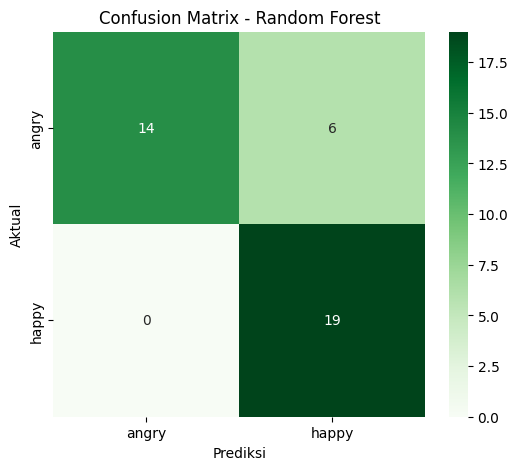

In [25]:
#OPSIONAL

plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Define target_names using the label encoder's classes
target_names = le.classes_
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', # Ganti warna jadi Hijau biar beda
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [26]:
joblib.dump({'model': rf_model, 'scaler': scaler, 'encoder': le}, 'Model ML Acustic.pkl')

['Model ML Acustic.pkl']

# Model 3 (Deep Learning)

In [43]:
#@title Model Multilayer Perceptron (MLP)

tf.random.set_seed(42)
np.random.seed(42)
#Model MLP
model_dl = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],), name="Hidden_1"),
    Dense(16, activation='relu', name="Hidden_2"),
    Dense(1, activation='sigmoid', name="Output_Layer")
])

model_dl.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#Train test
start_time = time.time()


In [48]:
#@title Training test

#Pencegahan overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

#Train test
history = model_dl.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

end_time = time.time()
training_duration = end_time - start_time
print(f"Training Time: {end_time - start_time:.2f} detik")
print(f"Training Selesai!")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6111 - loss: 0.7475 - val_accuracy: 0.6774 - val_loss: 0.6823
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6357 - loss: 0.7414 - val_accuracy: 0.6452 - val_loss: 0.6889
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6302 - loss: 0.7332 - val_accuracy: 0.6452 - val_loss: 0.6882
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6396 - loss: 0.7252 - val_accuracy: 0.6452 - val_loss: 0.6844
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6228 - loss: 0.7173 - val_accuracy: 0.6452 - val_loss: 0.6759
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6189 - loss: 0.7087 - val_accuracy: 0.6774 - val_loss: 0.6682
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6060 - loss: 0.7000 - val_accuracy: 0.6774 - val_loss: 0.6662
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6060 - loss: 0.6930 - val_accuracy: 0.6774 - val_loss: 0.6642


In [29]:
# Tampilkan Summary
print("MODEL SUMMARY")
model_dl.summary()

MODEL SUMMARY


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_1 (Dense)                │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_2 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,309 (9.02 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,540 (6.02 KB)

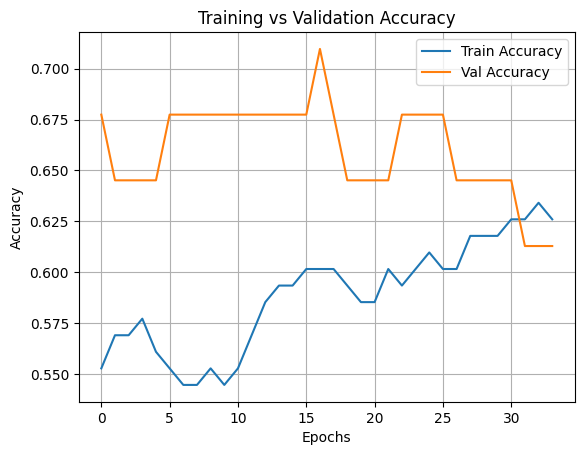

In [49]:
#Accurasion Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


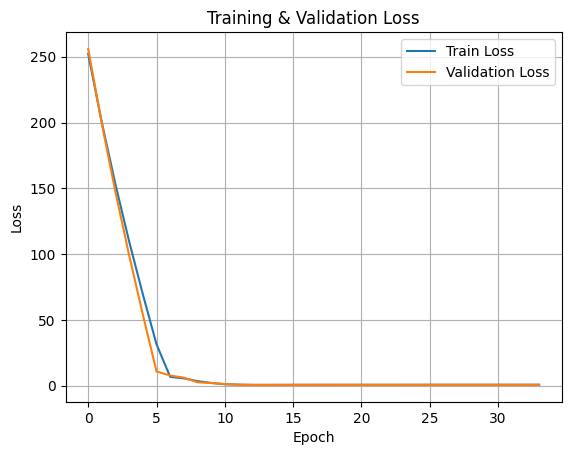

In [46]:
# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [32]:
#Prediksi Dan Evaluasi

print("\n 4. EVALUASI TEST SET")
y_pred_prob = model_dl.predict(X_test)
# Ubah ke 0 atau 1 (Threshold 0.5)
y_pred_dl = (y_pred_prob > 0.5).astype(int).flatten()
acc_dl = accuracy_score(y_test, y_pred_dl)
print(f"Akurasi Akhir pada Test Set: {acc_dl*100:.2f}%")

# Tampilkan Classification Report
print(classification_report(y_test, y_pred_dl, target_names=target_names))


 4. EVALUASI TEST SET
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Akurasi Akhir pada Test Set: 76.92%
              precision    recall  f1-score   support

       angry       0.92      0.60      0.73        20
       happy       0.69      0.95      0.80        19

    accuracy                           0.77        39
   macro avg       0.81      0.77      0.76        39
weighted avg       0.81      0.77      0.76        39



In [50]:
model_filename = 'model_3_deep_learning.h5'
model_dl.save(model_filename)
print(f"Berhasil menyimpan model ke: {model_filename}")

scaler_filename = 'scaler_deep_learning.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Berhasil menyimpan scaler ke: {scaler_filename}")

Berhasil menyimpan model ke: model_3_deep_learning.h5
Berhasil menyimpan scaler ke: scaler_deep_learning.pkl


# 4. EVALUATION


=== HASIL MODEL 1 (LOGISTIC REGRESSION) ===
Accuracy : 0.7436
Precision: 0.7143
Recall   : 0.7895
F1-Score : 0.7500
Inference Time: 0.004964 seconds


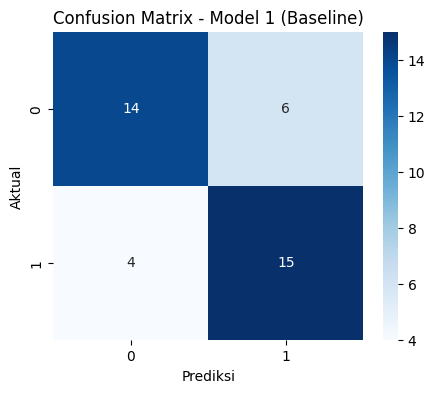

In [34]:
#@title Hasil Evaluasi Model

#Evaluasi Model 1 (Baseline)
start_time = time.time()
y_pred_1 = model_baseline.predict(X_test)
end_time = time.time()
inference_time_1 = end_time - start_time

# 2. Hitung Metrik
acc_1 = accuracy_score(y_test, y_pred_1)
prec_1 = precision_score(y_test, y_pred_1)
rec_1 = recall_score(y_test, y_pred_1)
f1_1 = f1_score(y_test, y_pred_1)

print("=== HASIL MODEL 1 (LOGISTIC REGRESSION) ===")
print(f"Accuracy : {acc_1:.4f}")
print(f"Precision: {prec_1:.4f}")
print(f"Recall   : {rec_1:.4f}")
print(f"F1-Score : {f1_1:.4f}")
print(f"Inference Time: {inference_time_1:.6f} seconds")

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_1), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Model 1 (Baseline)')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

HASIL MODEL 2 (RANDOM FOREST)
Accuracy : 0.8462
Precision: 0.7600
Recall   : 1.0000
F1-Score : 0.8636
Inference Time: 0.022254 seconds



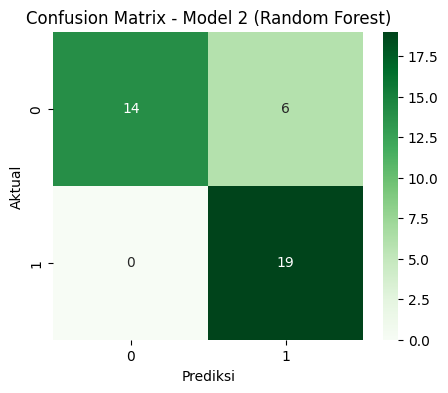

In [35]:
# @title Model 2 (Random Forest)

# 1. Hitung Inference Time
start_time = time.time()
y_pred_2 = rf_model.predict(X_test)
end_time = time.time()
inference_time_2 = end_time - start_time

# 2. Hitung Metrik
acc_2 = accuracy_score(y_test, y_pred_2)
prec_2 = precision_score(y_test, y_pred_2)
rec_2 = recall_score(y_test, y_pred_2)
f1_2 = f1_score(y_test, y_pred_2)

print("HASIL MODEL 2 (RANDOM FOREST)")
print(f"Accuracy : {acc_2:.4f}")
print(f"Precision: {prec_2:.4f}")
print(f"Recall   : {rec_2:.4f}")
print(f"F1-Score : {f1_2:.4f}")
print(f"Inference Time: {inference_time_2:.6f} seconds")
print()
# 3. Visualisasi Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_2), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Model 2 (Random Forest)')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

# (Feature Importance sudah ditampilkan di Bab 6.2, bisa Anda skip di sini atau panggil ulang)


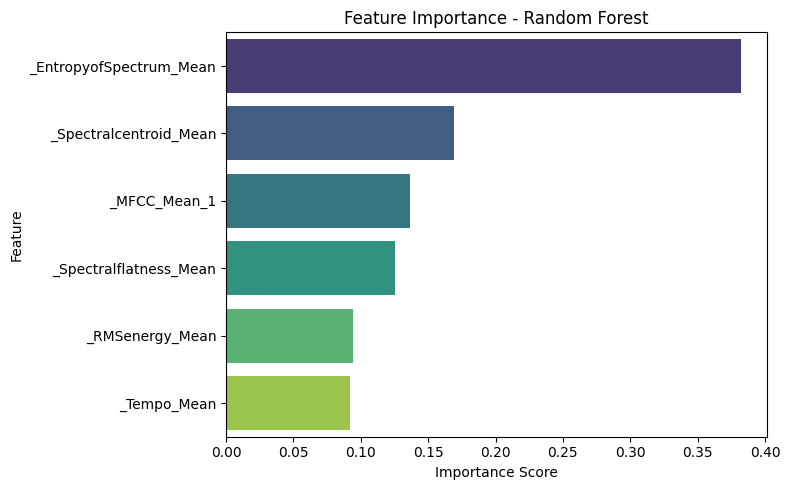

In [36]:
#@title Feature Importance - Random Forest

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='viridis'
)

plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

=== HASIL MODEL 3 (DEEP LEARNING) ===
Accuracy : 0.7692
Precision: 0.6923
Recall   : 0.9474
F1-Score : 0.8000
Inference Time: 0.147815 seconds


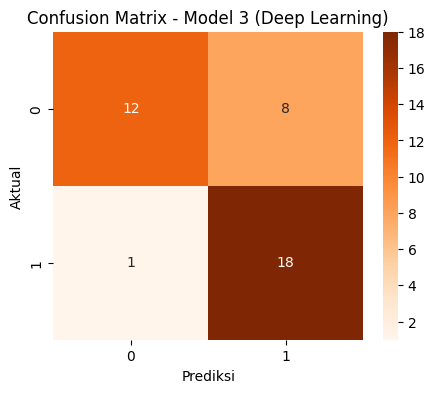

In [37]:
# @title Model 3 (Deep Learning)

start_time = time.time()
# Ingat: DL outputnya probabilitas, harus diubah ke 0/1
y_pred_prob = model_dl.predict(X_test, verbose=0)
y_pred_3 = (y_pred_prob > 0.5).astype(int).flatten()
end_time = time.time()
inference_time_3 = end_time - start_time

# 2. Hitung Metrik
acc_3 = accuracy_score(y_test, y_pred_3)
prec_3 = precision_score(y_test, y_pred_3)
rec_3 = recall_score(y_test, y_pred_3)
f1_3 = f1_score(y_test, y_pred_3)

print("=== HASIL MODEL 3 (DEEP LEARNING) ===")
print(f"Accuracy : {acc_3:.4f}")
print(f"Precision: {prec_3:.4f}")
print(f"Recall   : {rec_3:.4f}")
print(f"F1-Score : {f1_3:.4f}")
print(f"Inference Time: {inference_time_3:.6f} seconds")

# 3. Visualisasi Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_3), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Model 3 (Deep Learning)')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

In [38]:
# Prediksi probabilitas (Class 1)
y_prob_dl = model_dl.predict(X_test).flatten()
y_pred_dl = (y_prob_dl >= 0.5).astype(int).flatten()

# Buat DataFrame hasil prediksi
df_test_predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_dl,
    'Probability (Class 1)': np.round(y_prob_dl, 4)
})

print("Contoh Hasil Prediksi Model Deep Learning (Test Set):")
df_test_predictions.head(10)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Contoh Hasil Prediksi Model Deep Learning (Test Set):


,Actual,Predicted,Probability (Class 1)
0,0,1,0.8224
1,1,1,0.8269
2,1,1,0.5300
3,1,1,0.6272
4,0,0,0.3373
5,0,1,0.6390
6,1,1,0.8464
7,0,0,0.3511
8,0,0,0.3778
9,1,1,0.7880


In [39]:
#@title 4.3 Perbandingan Ketiga Model

train_time_1 = 0
train_time_2 = 0
train_time_3 = training_duration

data_komparasi = {
    'Model': [
        'Model 1 (Baseline)',
        'Model 2 (Random Forest)',
        'Model 3 (Deep Learning)'
    ],
    'Accuracy': [
        acc_1,
        acc_2,
        acc_3
    ],
    'Precision': [prec_1, prec_2, prec_3],
    'Recall': [rec_1, rec_2, rec_3],
    'F1-Score': [f1_1, f1_2, f1_3],
    'Training Time (s)': [
        train_time_1,
        train_time_2,
        train_time_3
    ],
    'Inference Time (s)': [
        inference_time_1,
        inference_time_2,
        inference_time_3
    ]
}

df_perbandingan = pd.DataFrame(data_komparasi)
pd.options.display.float_format = '{:.4f}'.format

# Menampilkan Tabel
print("TABEL PERBANDINGAN PERFORMA MODEL")
display(df_perbandingan)

TABEL PERBANDINGAN PERFORMA MODEL


,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s),Inference Time (s)
0,Model 1 (Baseline),0.7436,0.7143,0.7895,0.7500,0.0000,0.0050
1,Model 2 (Random Forest),0.8462,0.7600,1.0000,0.8636,0.0000,0.0223
2,Model 3 (Deep Learning),0.7692,0.6923,0.9474,0.8000,5.3275,0.1478


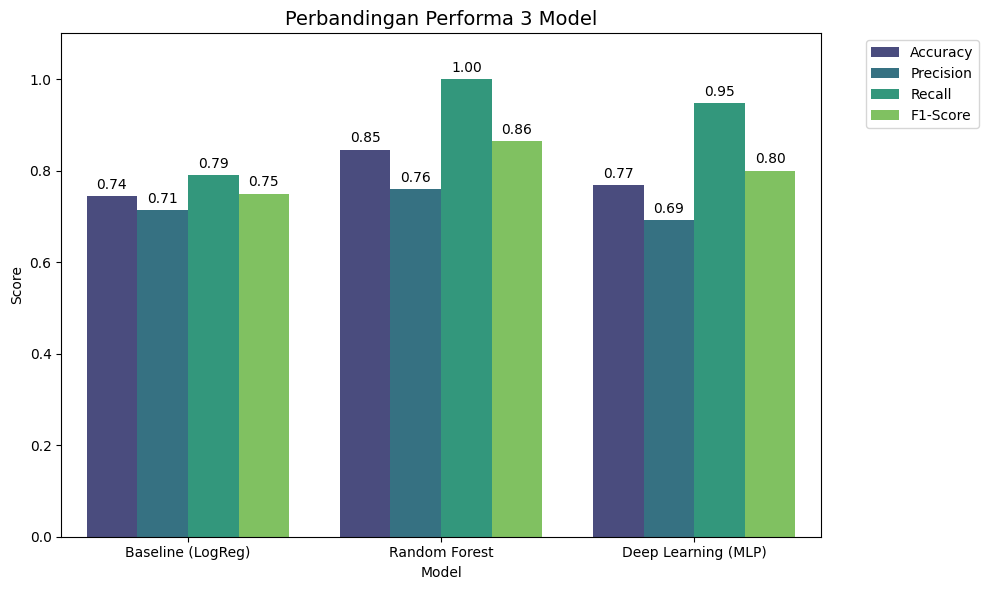

In [40]:
comparison_data = {
    'Model': ['Baseline (LogReg)', 'Random Forest', 'Deep Learning (MLP)'],
    'Accuracy': [acc_1, acc_2, acc_3],
    'Precision': [prec_1, prec_2, prec_3],
    'Recall': [rec_1, rec_2, rec_3],
    'F1-Score': [f1_1, f1_2, f1_3],
    'Inference Time (s)': [inference_time_1, inference_time_2, inference_time_3]
}

df_compare = pd.DataFrame(comparison_data)
# 2. Visualisasi Perbandingan (Bar Chart)
df_melted = df_compare.melt(id_vars="Model",
                            value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                            var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted, palette='viridis')
plt.title('Perbandingan Performa 3 Model', fontsize=14)
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Tambahkan angka di atas bar
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()